# Thông tin sinh viên

* Họ tên: Mai Duy Nam
* MSSV: 19120298

# Nạp dữ liệu

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set_theme(style='whitegrid')

In [2]:
df = pd.read_csv('a10.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


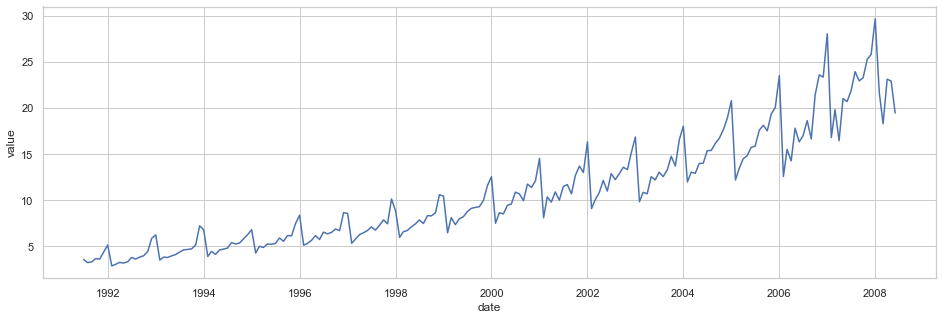

In [3]:
plt.figure(figsize=(16, 5))
sns.lineplot(data=df, x='date', y='value')
plt.show()

# SARIMA

## Giải thích mô hình SARIMA

Mô hình SARIMA là một cải tiến của mô hình ARIMA, được áp dụng để mô hình hóa dữ liệu chuỗi thời gian có tính mùa vụ. SARIMA được khớp trên dữ liệu để hiểu dữ liệu tốt hơn hoặc dự đoán giá trị trong tương lai.

Để hiểu rõ về SARIMA ta cần hiểu về mô hình ARIMA. Gọi $y_t$ là giá trị của chuỗi thời gian $y$ tại thời điểm $t$. Mô hình ARIMA dự đoán giá trị của $y_t$ dựa trên ba tham số $p, d, q$ như sau:

$$ \hat{y}_t = c + \sum_{i=1}^{p} \phi_i z^{(d)}_{t-i} + \sum_{j=1}^{q} \theta_j \epsilon_{t-j} $$

Trong đó, $z^{(d)}_t$ đại diện cho chuỗi sai phân bậc $d$ của $y_t$, tức $z^{(d)}_t = (1-B)^dy_t$, với $B$ là backshift operator. Nói nôm na, mô hình ARIMA dự đoán giá trị $\hat{y}_t$ vào ngày thứ $t$ dựa trên:
* Giá trị $y_{i-1}, y_{i-2}, \dots, y_{i-p}$ (hoặc sai phân $z^{(d)}_{t-1}, \dots, z^{(d)}_{t-p}$) của $p$ ngày trước.
* Độ lỗi $\epsilon_{t-1}, \dots, \epsilon_{t-q}$ của $q$ ngày trước đó.

SARIMA bổ sung cho ARIMA ở chỗ nó tính thêm cả tính mùa vụ của dữ liệu. Mô hình SARIMA có tổng cộng 7 tham số: $(p, d, q)$ và $(P, D, Q)_m$. Ba tham số $p, d, q$ tương ứng với ba phần AR (autoregressive), I (integrated) và MA (moving average), tương tự với $p, d, q$ trong mô hình ARIMA. Các tham số $P, D, Q$ cũng tương ứng với ba phần AR, I, và MA nhưng áp dụng cho thành phần mùa vụ của chuỗi thời gian. Tham số $m$ là số observation trong một năm.

## Xây dựng mô hình SARIMA

Trước khi xây dựng mô hình, do dữ liệu có tính seasonal với chu kỳ là 12 (tương ứng $m = 12$), ta khử đi tính mùa vụ bằng cách lấy difference với lag bằng 12 tháng.

In [4]:
df['seasonal_removed'] = df['value'].diff(12)

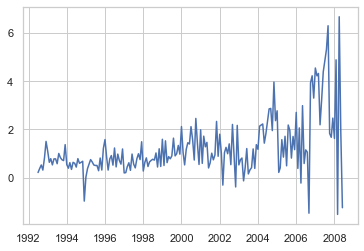

In [5]:
plt.plot(df['seasonal_removed'])
plt.show()

Có thể thấy dữ liệu có variance tương đối lớn vào giai đoạn 2006 - 2008. Ở đây do trung bình của chuỗi thời gian có vẻ lớn hơn 0 một chút, ta thử lấy difference với lag bằng 1 trên dữ liệu đã khử tính mùa vụ.

In [6]:
df['seasonal_removed_diff1'] = df['seasonal_removed'].diff()

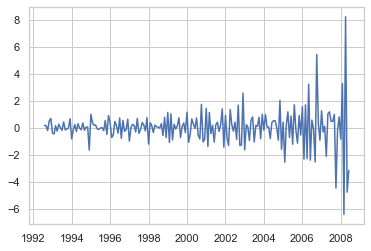

In [7]:
plt.plot(df['seasonal_removed_diff1']);

Để xác định các tham số $p, d, q, P, D, Q$, ta vẽ các biểu đồ ACF và PACF trên dữ liệu với lag = 0 và lag = 1.

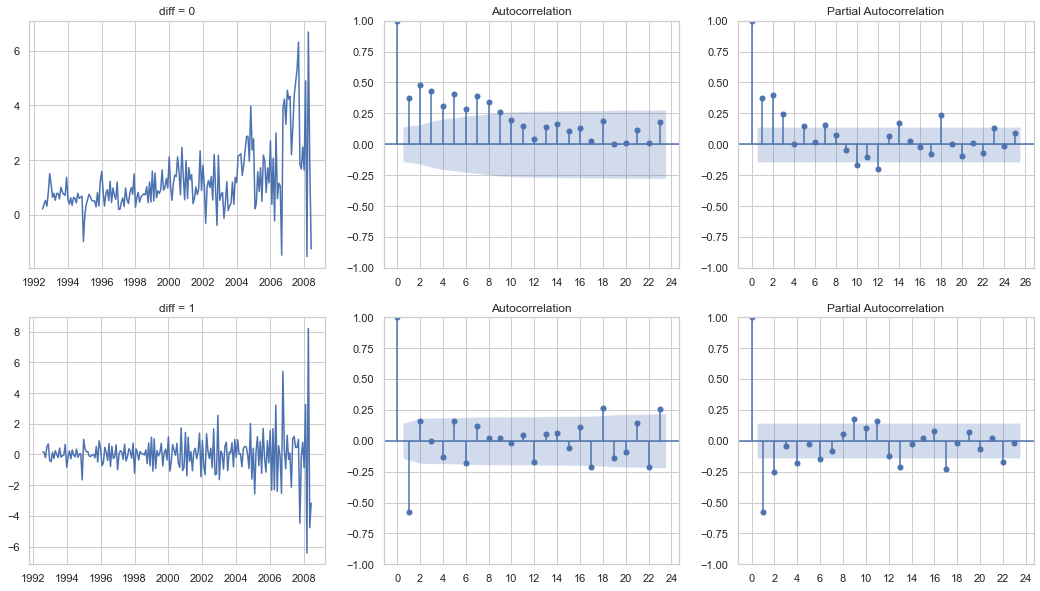

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Diff 0
diff0_axes = axes[0]
diff0_axes[0].plot(df['seasonal_removed'])
plot_acf(df['seasonal_removed'].dropna(), ax=diff0_axes[1])
plot_pacf(df['seasonal_removed'].dropna(), ax=diff0_axes[2], method='ywm', lags=25)

diff0_axes[0].set_title('diff = 0')
diff0_axes[1].xaxis.set_major_locator(MultipleLocator(2))
diff0_axes[2].xaxis.set_major_locator(MultipleLocator(2))
diff0_axes[1].xaxis.set_minor_locator(MultipleLocator(1))
diff0_axes[2].xaxis.set_minor_locator(MultipleLocator(1))

# Diff 1
diff1_axes = axes[1]
diff1_axes[0].plot(df['seasonal_removed_diff1'])
plot_acf(df['seasonal_removed_diff1'].dropna(), ax=diff1_axes[1])
plot_pacf(df['seasonal_removed_diff1'].dropna(), ax=diff1_axes[2], method='ywm')

diff1_axes[0].set_title('diff = 1')
diff1_axes[1].xaxis.set_major_locator(MultipleLocator(2))
diff1_axes[2].xaxis.set_major_locator(MultipleLocator(2))
diff1_axes[1].xaxis.set_minor_locator(MultipleLocator(1))
diff1_axes[2].xaxis.set_minor_locator(MultipleLocator(1))

plt.show()

Trong biểu đồ với diff = 0, giá trị lớn của PACF tại lag 12 cho thấy mô hình của ta có thành phần mùa vụ với $P = 1$. Hình dạng của ACF không cho thấy tính mùa vụ rõ ràng, do đó ta chọn $Q = 0$.

Đối với biểu đồ diff = 1, ACF của chuỗi thời gian có hệ số lớn ở lag 1 và PACF có hệ số lớn ở lag 1 và 2, do đó ta chọn $p = 2, q = 1, d = 1$.

### Xây dựng mô hình

In [9]:
train_end = dt.datetime(2007, 1, 1)

train = df[:train_end]['value'].copy()
test = df[train_end + dt.timedelta(days=1):]['value'].copy()

Ta xây dựng mô hình SARIMA với các tham số $(p, d, q)(P, D, Q)_m = (2, 1, 1)(1, 1, 0)_{12}$. Lưu ý, ta sử dụng $D = 1$ do ta đang train mô hình trên tập dữ liệu gốc (cột `value`). Khi ta phân tích để chọn $P, Q$ lúc nãy, ta sử dụng cột `seasonal_removed` tức ta đã xét trên dữ liệu với $D = 1$ rồi.

In [10]:
order = (2, 1, 1)
seasonal_order = (1, 1, 0, 12)
model_sarima = SARIMAX(train, order=order, seasonal_order=seasonal_order)

/home/mdnam/.local/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/mdnam/.local/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [11]:
%%time
model_sarima_fitted = model_sarima.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07241D+00    |proj g|=  4.62182D-02

At iterate    5    f=  1.06814D+00    |proj g|=  5.81875D-02

At iterate   10    f=  1.05969D+00    |proj g|=  2.57328D-02

At iterate   15    f=  1.05366D+00    |proj g|=  1.72214D-02

At iterate   20    f=  1.05334D+00    |proj g|=  7.89706D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     31      1     0     0   7.897D-06   1.053D+00
  F =   1.0533420669731111     

CONVERG

### Đánh giá

In [12]:
print(model_sarima_fitted.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                  187
Model:             SARIMAX(2, 1, 1)x(1, 1, [], 12)   Log Likelihood                -196.975
Date:                             Tue, 10 May 2022   AIC                            403.950
Time:                                     17:17:54   BIC                            419.745
Sample:                                 07-01-1991   HQIC                           410.357
                                      - 01-01-2007                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1080      0.062      1.735      0.083      -0.014       0.230
ar.L2          0.2697      

Dưới đây là dự đoán của mô hình trong một năm từ 2007 đến 2008. Có thể thấy mô hình đã bắt được trend và hình dạng chung của dữ liệu. Một điều lưu ý là việc mô hình dự đoán tương đối chính xác trong giai đoạn đầu năm và cuối năm 2007, nhưng lại dự đoán không thực sự tốt vào giai đoạn giữa năm 2007 và đầu năm 2008. Tuy vậy hình dạng của đường line thì lại được dự đoán đúng (ví dụ, mô hình dự đoán được 2 cực đại địa phương vào tháng 5 và tháng 8, nhưng không dự đoán đúng giá trị của hai cực đại này). Biểu đồ residual cho thấy các sai số này.

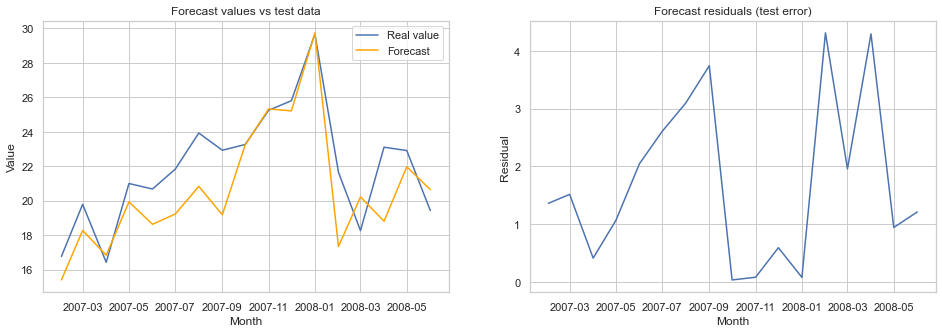

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(test)
axes[0].plot(model_sarima_fitted.forecast(len(test)), color='orange')
axes[0].legend(['Real value', 'Forecast'])

axes[0].set_title('Forecast values vs test data')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Value')

axes[1].plot(np.abs(test - model_sarima_fitted.forecast(len(test))))

axes[1].set_title('Forecast residuals (test error)')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Residual')
plt.show()

Biểu đồ dưới đây so sánh dự đoán của mô hình so với dữ liệu gốc, cùng với dữ liệu gốc của 12 tháng trước đó (1 mùa trước). Gợi nhớ khi nãy ta xây dựng mô hình với $P = 1$, có thể thấy dưới đây mô hình đã bắt khá tốt hình dạng của dữ liệu trong năm 2006 (dữ liệu dùng để huấn luyện mô hình và có ảnh hưởng lớn đến mô hình).

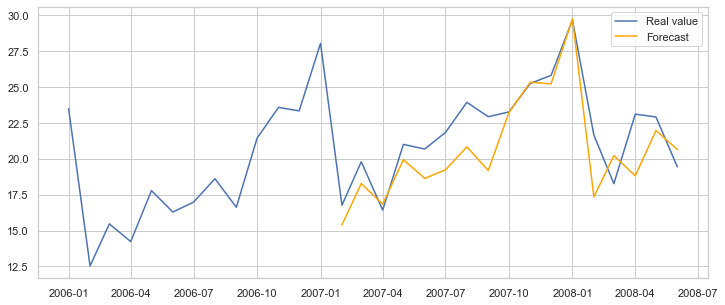

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(df.loc[dt.datetime(2006, 1, 1):]['value'])
plt.plot(model_sarima_fitted.forecast(len(test)), color='orange')
plt.legend(['Real value', 'Forecast'])
plt.show()

## Dự báo

Dưới đây ta fit mô hình trên toàn bộ dữ liệu gốc và thực hiện dự đoán trong vòng một năm.

In [15]:
model_sarima_all = SARIMAX(df['value'], order=order, seasonal_order=seasonal_order).fit()

/home/mdnam/.local/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/mdnam/.local/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30178D+00    |proj g|=  1.31724D-01

At iterate    5    f=  1.28908D+00    |proj g|=  7.76475D-04

At iterate   10    f=  1.28836D+00    |proj g|=  3.46292D-02

At iterate   15    f=  1.28150D+00    |proj g|=  6.22346D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     28      1     0     0   9.971D-06   1.281D+00
  F =   1.2814436997314271     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


Hình dưới đây cho thấy dự đoán của mô hình trong vòng 12 tháng cùng với khoảng tin cậy.

In [16]:
forecast = model_sarima_all.get_forecast(12)
yhat = forecast.predicted_mean
confidence_interval = forecast.conf_int()['upper value'] - yhat

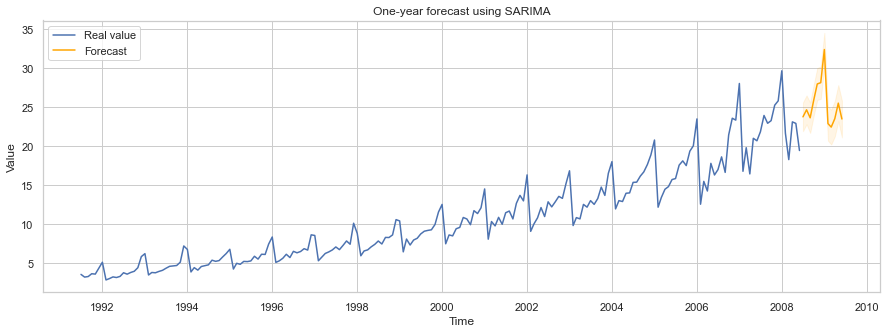

In [17]:
plt.figure(figsize=(15, 5))
plt.plot(df['value'])
plt.plot(yhat, color='orange')
plt.fill_between(yhat.index, yhat - confidence_interval, yhat + confidence_interval, alpha=0.1, color='orange')
plt.legend(['Real value', 'Forecast'])
plt.title('One-year forecast using SARIMA')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()